In [278]:
cfg={
    'main_folder':'/Users/matejkvassay/data/sketch-testing/',
    'save_allowed':True,
    'dataset_file':'dataset.npy',
    'testset_file': 'testset.npy',
    'dev_mode': False,
    'dev_mode_dataset_count_limit': 10000,
    'dist_estimation_ref_obj_count': 100,
    'dist_estimation_p_vals':[1,2],
    'evaluation_set_query_obj_cnt':1000,
    'evaluation_set_result_set_size':100,
    'ghp_pivot_couple_candidates': 5000,
    'min_balancing_score': 0.1,
    'after_partitiong_checkpoint_file': 'after_partitioning.checkpoint'
}

In [2]:
%matplotlib inline
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from scipy.spatial.distance import minkowski, hamming
from fractions import Fraction 
from time import time
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import pylab
import scipy as sp
import cPickle

In [3]:
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)

In [4]:
def log_pfx(obj, msg, *args):
    logger.info(obj.__class__.__name__+'| '+msg, *args)
    
def save_to(obj, file_path):
    with open(file_path, 'wb') as f:
        cPickle.dump(obj,f)

def load_from(file_path):
    with open(file_path, 'rb') as f:
        return cPickle.load(f)

def show_text(title,xlabel,ylabel):
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def heatmap(x,y,bins=50,figsize=(5,5),title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=figsize)
    heatmap, xedges, yedges = np.histogram2d(x, y, bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    show_text(title,xlabel,ylabel)
    plt.show()
    
def scatter(x,y,title=None, xlabel=None, ylabel=None, point_size=5):
    plt.scatter(x, y, s=[point_size for _ in range(len(x))])
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def scatter_array(arr, title=None, xlabel=None, ylabel=None, point_size=5):
    ser=pd.Series(arr)
    plt.scatter(ser.index, ser, s=[point_size for _ in range(len(arr))])
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def plot_array(arr, title=None, xlabel=None, ylabel=None,xticks=None):
    pd.Series(arr).plot(grid=True)
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xticks:
        plt.xticks(len(arr), labels, rotation='vertical')
    plt.show()

def hist_array(arr,bins=50, title=None, xlabel=None, ylabel=None):
    pd.Series(arr).hist(bins=bins,grid=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle(title)
    plt.show()
    
def restrict_2d_space(x,y,x_interval, y_interval):
    conditions=[x>=x_interval[0], x<=x_interval[1], y>=y_interval[0], y<=y_interval[1]]
    mask=conditions[0]
    for condition in conditions[1:]:
        mask=np.logical_and(mask,condition)
    return x[mask], y[mask]


def balanced_correlation(col1, col2):
    '''
    Correlation when bits are balanced - |4*(a/n) - 1|, where a is CARD(NOT(XOR(A,B)))
    '''
    a=float(np.sum(np.logical_not(np.logical_xor(v1,v2))))
    n=col1.shape[0]
    return np.absolute((4.0*(a/n)) - 1.0)

class IterationLogger(object):
    def __init__(self, message='Started iteration no.: %s\n Time from previous iteration: %ss\n Time from start: %ss',log_by=1000):
        self.log_by=log_by
        self.num_iter=0
        self.msg=message
        self.time_started=None
        self.time_this_iter=None
        
    def next_iter(self):
        if self.time_this_iter is None:
            self.time_this_iter=time()
        if self.time_started is None:
            self.time_started=time()
        self.num_iter+=1
        if self.num_iter%self.log_by==0:
            dur_from_previous=time()-self.time_this_iter
            self.time_this_iter=time()
            dur_from_start=time()-self.time_started
            log_pfx(self, self.msg, str(self.num_iter), str(dur_from_previous), str(dur_from_start))
            

### LOAD DATA

Database 

In [5]:
dataset_path=cfg['main_folder']+cfg['dataset_file']

In [6]:
with open(dataset_path, 'rb') as f:
    decaf_vecs=np.load(f)
if cfg['dev_mode']:
    decaf_vecs=decaf_vecs[:cfg['dev_mode_dataset_count_limit']]
obj_ids=np.arange(len(decaf_vecs))

In [7]:
decaf_vecs.shape #(vectors count, vector length)

(69318, 4096)

Test data (not included in database)

In [280]:
testset_path=cfg['main_folder']+cfg['testset_file']

In [281]:
with open(testset_path, 'rb') as f:
    test_vecs=np.load(f)
test_ids=np.arange(len(decaf_vecs))

In [282]:
test_vecs.shape

(17330, 4096)

### DATA ANALYSIS


#### Distance distribution estimation

In [8]:
def estimate_minkowski_dist_distr(vec_matrix, ref_obj_cnt, p):
    '''
    p can be either single value or list of p parameters for minkowski distance
    '''
    distances=[list() for _ in range(len(p))]
    reference_objs=vec_matrix[np.random.choice(vec_matrix.shape[0], size=ref_obj_cnt, replace=False)] #sampling without replacement
    iter_log=IterationLogger(log_by=5000)
    for decaf_vec in decaf_vecs:
        iter_log.next_iter()
        for ref_obj in reference_objs:
            for i, val_p in enumerate(p):
                dist=minkowski(ref_obj, decaf_vec, p=val_p)
                distances[i].append(dist)
    return tuple(distances)


In [9]:
dist_l1, dist_l2 = estimate_minkowski_dist_distr(decaf_vecs,  cfg['dist_estimation_ref_obj_count'], cfg['dist_estimation_p_vals'])

2017-05-02 23:21:22,033 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 27.1620249748s
 Time from start: 27.1620411873s
2017-05-02 23:21:50,079 - root - INFO - IterationLogger| Started iteration no.: 10000
 Time from previous iteration: 28.0465738773s
 Time from start: 55.2086160183s
2017-05-02 23:22:15,900 - root - INFO - IterationLogger| Started iteration no.: 15000
 Time from previous iteration: 25.8211140633s
 Time from start: 81.0297310352s
2017-05-02 23:22:42,943 - root - INFO - IterationLogger| Started iteration no.: 20000
 Time from previous iteration: 27.0430901051s
 Time from start: 108.072822094s
2017-05-02 23:23:07,488 - root - INFO - IterationLogger| Started iteration no.: 25000
 Time from previous iteration: 24.5443689823s
 Time from start: 132.61719203s
2017-05-02 23:23:31,869 - root - INFO - IterationLogger| Started iteration no.: 30000
 Time from previous iteration: 24.3815381527s
 Time from start: 156.99873209s
2017-05-02 23

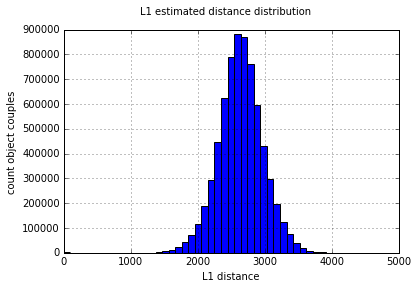

In [10]:
hist_array(dist_l1, bins=50, title='L1 estimated distance distribution',ylabel='count object couples', xlabel='L1 distance')

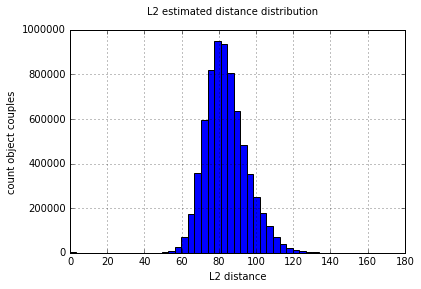

In [11]:
hist_array(dist_l2, bins=50,title='L2 estimated distance distribution',ylabel='count object couples', xlabel='L2 distance')

## GENERATE APPROXIMATION  EVALUATION SET
We select 100 query objects and their 100 closest object's id's from the dataset to evaluate. It simulates the scenario where almost never more than 100 objects are required for result set. 

In [12]:
eval_queries_indicies=np.random.choice(decaf_vecs.shape[0], size=cfg['evaluation_set_query_obj_cnt'], replace=False)
eval_queries_vecs=decaf_vecs[eval_queries_indicies] 
eval_queries_ids=obj_ids[eval_queries_indicies]
eval_k=cfg['evaluation_set_result_set_size'] #k for knn to evaluation objects

In [13]:
eval_result_objs=[list() for _ in range(len(eval_queries_ids))]

Finds k-NN query result

In [14]:
iter_log=IterationLogger(log_by=5000)
for i in range(len(decaf_vecs)):
    iter_log.next_iter()
    candidate_vec=decaf_vecs[i]
    candidate_id=obj_ids[i]
    for j in range(len(eval_queries_vecs)):
        query_vec=eval_queries_vecs[j]
        dist=minkowski(candidate_vec, query_vec, p=1)
        if len(eval_result_objs[j])>0:
            if dist<eval_result_objs[j][-1][1]: #if object is not member of result set
                eval_result_objs[j].append((candidate_id, dist))
                eval_result_objs[j].sort(key=lambda x: x[1],reverse=False)
                if len(eval_result_objs[j])>eval_k:#if > k objects remove last one
                    del eval_result_objs[j][-1] 
        else:
            eval_result_objs[j].append((candidate_id, dist))
            

2017-05-02 23:29:29,467 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 153.121083975s
 Time from start: 153.121083021s
2017-05-02 23:31:46,738 - root - INFO - IterationLogger| Started iteration no.: 10000
 Time from previous iteration: 137.270857096s
 Time from start: 290.391941071s
2017-05-02 23:34:02,134 - root - INFO - IterationLogger| Started iteration no.: 15000
 Time from previous iteration: 135.396121979s
 Time from start: 425.788064003s
2017-05-02 23:36:20,524 - root - INFO - IterationLogger| Started iteration no.: 20000
 Time from previous iteration: 138.389902115s
 Time from start: 564.177968025s
2017-05-02 23:38:42,665 - root - INFO - IterationLogger| Started iteration no.: 25000
 Time from previous iteration: 142.140115023s
 Time from start: 706.318083048s
2017-05-02 23:40:58,410 - root - INFO - IterationLogger| Started iteration no.: 30000
 Time from previous iteration: 135.745887995s
 Time from start: 842.063971996s
2017-05-02 

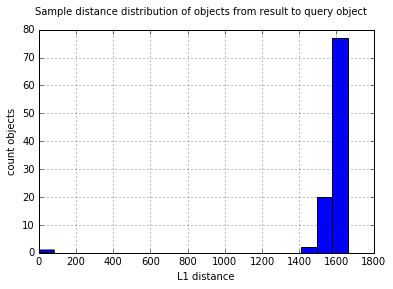

In [15]:
hist_array([obj[1] for obj in eval_result_objs[17]],bins=20,title='Sample distance distribution of objects from result to query object',xlabel='L1 distance',ylabel='count objects')

## GENERALIZED HYPERPLANE PARTITIONING PIVOTS SELECTION

In [16]:
pivot_cand_cpl_cnt=cfg['ghp_pivot_couple_candidates']

Select random pivot couples

In [17]:
cand_indicies=np.random.choice(decaf_vecs.shape[0], size=pivot_cand_cpl_cnt*2, replace=False)
pivot_cand_vecs=decaf_vecs[cand_indicies]
pivot_cand_ids=obj_ids[cand_indicies]
pivot_cand_vecs_a, pivot_cand_vecs_b=np.split(pivot_cand_vecs,2)
pivot_cand_ids_a, pivot_cand_ids_b=np.split(pivot_cand_ids,2)
pivot_cand_vecs=np.array(zip(pivot_cand_vecs_a, pivot_cand_vecs_b))
pivot_cand_ids=np.array(zip(pivot_cand_ids_a, pivot_cand_ids_b))

In [18]:
def get_ghp_partition(vec, pivot_a, pivot_b, p=1):
    '''
    returns partition 0/1 and distance to closest pivot
    '''
    dist_a=minkowski(vec, pivot_a[0], p=p)
    dist_b=minkowski(vec, pivot_b[1], p=p)
    if dist_a<dist_b:
        return 1, dist_a
    if dist_a>dist_b:
        return 0, dist_b
    return np.random.choice([0,1]), dist_a
    
def compute_part_balance(cnt_partition, cnt_all):
    '''
    1 - 2*|0.5-x/y| where x is count members in left or right partition and y is count all members
    '''
    return 1.0-(2*abs(0.5-(cnt_partition/cnt_all)))

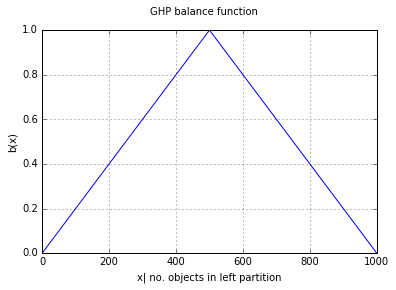

In [19]:
#plot balance function
plot_array([compute_part_balance(float(num),float(1000)) for num in range(0,1001)], title='GHP balance function',xlabel='x| no. objects in left partition',ylabel='b(x)')



Partition all objects from database and collect useful statistics for pivot couple selection

In [20]:
partitions=np.zeros(shape=(decaf_vecs.shape[0], len(pivot_cand_ids)), dtype=np.float32)
left_members_cnt=np.zeros(len(pivot_cand_ids), dtype=np.float32)
sum_dist_from_ghp=np.zeros(len(pivot_cand_ids), dtype=np.float32)

In [21]:
iter_log=IterationLogger(log_by=1000)
for i, vec in enumerate(decaf_vecs):
    iter_log.next_iter()
    for j, pivot_cpl_vec in enumerate(pivot_cand_vecs):
        partition,dist=get_ghp_partition(vec, pivot_cpl_vec[0], pivot_cpl_vec[1], p=1)
        partitions[i][j]=partition
        left_members_cnt[j]+=partition
        sum_dist_from_ghp[j]+=dist

2017-05-03 00:03:27,477 - root - INFO - IterationLogger| Started iteration no.: 1000
 Time from previous iteration: 311.852498055s
 Time from start: 311.852499962s
2017-05-03 00:08:28,871 - root - INFO - IterationLogger| Started iteration no.: 2000
 Time from previous iteration: 301.394361973s
 Time from start: 613.246861935s
2017-05-03 00:13:43,273 - root - INFO - IterationLogger| Started iteration no.: 3000
 Time from previous iteration: 314.40151906s
 Time from start: 927.648381948s
2017-05-03 00:19:14,522 - root - INFO - IterationLogger| Started iteration no.: 4000
 Time from previous iteration: 331.248828173s
 Time from start: 1258.89721107s
2017-05-03 00:24:19,513 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 304.990841866s
 Time from start: 1563.88811612s
2017-05-03 00:29:04,194 - root - INFO - IterationLogger| Started iteration no.: 6000
 Time from previous iteration: 284.681805134s
 Time from start: 1848.56992102s
2017-05-03 00:34:

Checkpoint

In [22]:
#Partitioning balance score
balance_scores=np.array([compute_part_balance(float(cnt), float(decaf_vecs.shape[0])) for cnt in left_members_cnt])

In [23]:
'''
Partitioning with low balancing score is useless for filtering thus we'll remove such pivot couples right away. 
'''
balance_limit=float(cfg['min_balancing_score'])
bal_mask=np.array([i for i, score in enumerate(balance_scores) if score>=balance_limit])
balance_scores=balance_scores[bal_mask]
pivot_cand_vecs=pivot_cand_vecs[bal_mask]
partitions=np.array(partitions).T[bal_mask].T
left_members_cnt=np.array(left_members_cnt)[bal_mask]
sum_dist_from_ghp=np.array(sum_dist_from_ghp)[bal_mask]

In [24]:
'''
Compute distance from dividing hyperplane score.
Scale all distances to 0-1, 1 being the largest.
HP distance score: (d_i - min(D))/(max(D)-min(D))
'''
avg_dist_from_hp=np.array([float(num)/decaf_vecs.shape[0] for num in sum_dist_from_ghp])

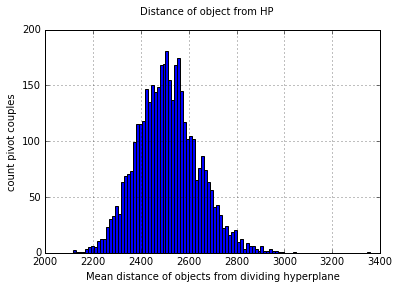

In [25]:
hist_array(avg_dist_from_hp, bins=100,xlabel='Mean distance of objects from dividing hyperplane', \
           ylabel='count pivot couples',title='Distance of object from HP')

We threw away all bits with balancing score below 0.1, from 5000 over 4000 reamained.

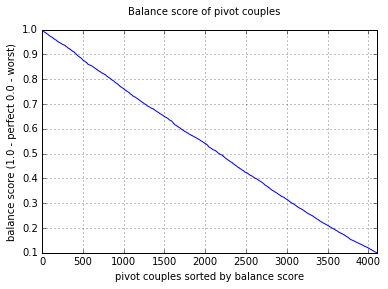

In [26]:
plot_array(sorted(balance_scores,reverse=True),title='Balance score of pivot couples', ylabel='balance score (1.0 - perfect 0.0 - worst)', xlabel='pivot couples sorted by balance score')

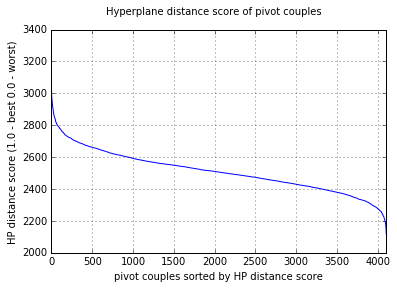

In [27]:
plot_array(sorted(avg_dist_from_hp,reverse=True),title='Hyperplane distance score of pivot couples', ylabel='HP distance score (1.0 - best 0.0 - worst)', xlabel='pivot couples sorted by HP distance score')

### Checkpoint

Save

In [28]:
if cfg['save_allowed']:
    save_to((decaf_vecs, eval_queries_vecs,eval_queries_ids, eval_k, pivot_cand_vecs,eval_result_objs,\
             pivot_cand_ids, partitions, balance_scores, avg_dist_from_hp),\
            cfg['main_folder']+cfg['after_partitiong_checkpoint_file'])

Load

In [29]:
decaf_vecs, eval_queries_vecs,\
eval_queries_ids, eval_k, \
pivot_cand_vecs,eval_result_objs,\
pivot_cand_ids, partitions, balance_scores,\
avg_dist_from_hp=load_from(cfg['main_folder']+cfg['after_partitiong_checkpoint_file'])

In [30]:
res=np.argmax(balance_scores, axis=None)

### Select balanced bits
Without balance filtering would be useless. Not even we risk visiting parition with too many objects inside, probability of visiting such partition is greater than visiting the smaller one.

In [31]:
balance_indicies=balance_scores.argsort()[::-1]
balance_indicies=balance_indicies[:500]
pivot_cand_vecs_bal=pivot_cand_vecs[balance_indicies]
pivot_cand_ids_bal=pivot_cand_ids[balance_indicies]
balance_scores_bal=balance_scores[balance_indicies]
avg_dist_from_hp_bal=avg_dist_from_hp[balance_indicies]
partitions_bal=partitions.T[balance_indicies].T

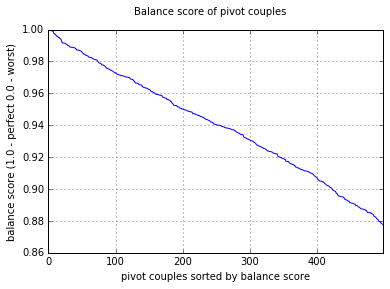

In [32]:
plot_array(sorted(balance_scores_bal,reverse=True),title='Balance score of pivot couples', ylabel='balance score (1.0 - perfect 0.0 - worst)', xlabel='pivot couples sorted by balance score')

## REMOVE CORRELATED BITS
In this section we evaluated three heuristics for uncorrelated bit subset selection. Two of them are optimized either for maximal correlation or mean correlation. Maximal correlation limits the worst bit rendundancy and Mean correlation represents overall information redundancy in sketchces.

In [198]:
def compute_corr_mtx(sketch_matrix):
    corr_mtx = np.absolute(np.corrcoef(sketch_matrix.T))
    np.fill_diagonal(corr_mtx, 0.0)
    return corr_mtx

def compute_mean_corr(corr_mtx, include=None, exclude=None):
    if include is None and exclude is None:
        u=np.triu_indices(n=corr_mtx.shape[0], m=corr_mtx.shape[1], k=1)
        return np.mean(corr_mtx[u])
    if include is not None:
        selection=corr_mtx[include].T[include]
        u=np.triu_indices(n=selection.shape[0], m=selection.shape[1], k=1)
        return np.mean(selection[u])
    if exclude is not None:
        mask = np.ones(corr_mtx.shape[0],dtype=bool)
        mask[exclude]=0
        selection=corr_mtx[mask].T[mask]
        u=np.triu_indices(n=selection.shape[0], m=selection.shape[1], k=1)
        return np.mean(selection[u])

def compute_max_corr(corr_mtx, include=None, exclude=None):
    if include is None and exclude is None:
        u=np.triu_indices(n=corr_mtx.shape[0], m=corr_mtx.shape[1], k=1)
        return np.max(corr_mtx[u])
    if include is not None:
        selection=corr_mtx[include].T[include]
        u=np.triu_indices(n=selection.shape[0], m=selection.shape[1], k=1)
        return np.max(selection[u])
    if exclude is not None:
        mask = np.ones(corr_mtx.shape[0],dtype=bool)
        mask[exclude]=0
        selection=corr_mtx[mask].T[mask]
        u=np.triu_indices(n=selection.shape[0], m=selection.shape[1], k=1)
        return np.max(selection[u])

In [199]:
M=compute_corr_mtx(partitions_bal)

In [200]:
sketch_lengths=range(0,64,1)

### Algorithm 1
Select K random subsets of specified length and choose the one with minimal pairwise correlation. This is a baseline approach.

In [201]:
def select_random_bit_subset(sketch_matrix, desired_length, k, by='max'):
    if desired_length<2:
        return 0.0,0.0,0.0
    indices=np.array(range(sketch_matrix.shape[1]))
    subsets=np.array([np.random.choice(indices,size=desired_length, replace=False) for _ in range(k)])
    best_subset=None
    best_corr_max=1.0
    best_corr_mean=1.0
    for subset_idx in subsets:
        if by=='max':
            corr_max=compute_max_corr(M, include=subset_idx)
            if corr_max<=best_corr_max:
                best_corr_max=corr_max
                best_subset=subset_idx
                best_corr_mean=compute_mean_corr(M, include=subset_idx)
        if by=='mean':
            corr_mean=compute_mean_corr(M, include=subset_idx)
            if corr_mean<=best_corr_mean:
                best_corr_mean=corr_mean
                best_subset=subset_idx
                best_corr_max=compute_max_corr(M, include=subset_idx)
    return best_subset, best_corr_max, best_corr_mean



In [202]:
K=1000
found_corrs_max=[list(),list()] #first by max, second by mean
found_corrs_mean=[list(),list()]
for sketch_length in sketch_lengths:
    _, best_corr_max, best_mean_corr=select_random_bit_subset(partitions_bal, sketch_length,k=K,by='max')
    found_corrs_max[0].append(best_corr_max)
    found_corrs_mean[0].append(best_mean_corr)
    _, best_corr_max, best_mean_corr=select_random_bit_subset(partitions_bal, sketch_length,k=K,by='mean')
    found_corrs_max[1].append(best_corr_max)
    found_corrs_mean[1].append(best_mean_corr)    

#### Algorithm 1 - optimized for max

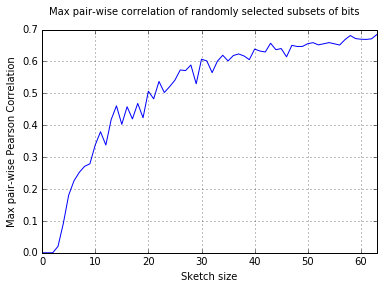

In [203]:
plot_array(found_corrs_max[0],title='Max pair-wise correlation of randomly selected subsets of bits', ylabel='Max pair-wise Pearson Correlation', xlabel='Sketch size')

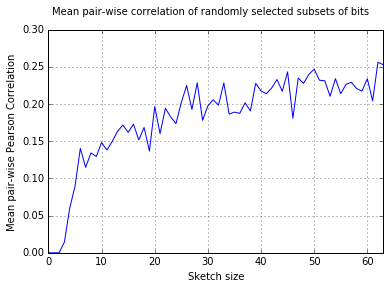

In [204]:
plot_array(found_corrs_mean[0],title='Mean pair-wise correlation of randomly selected subsets of bits', ylabel='Mean pair-wise Pearson Correlation', xlabel='Sketch size')

#### Algorithm 1 - optimized for mean 

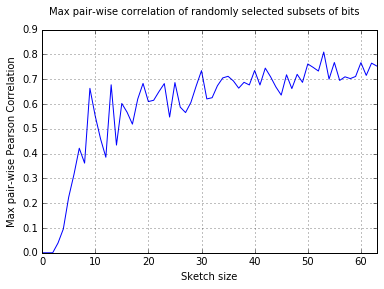

In [205]:
plot_array(found_corrs_max[1],title='Max pair-wise correlation of randomly selected subsets of bits', ylabel='Max pair-wise Pearson Correlation', xlabel='Sketch size')

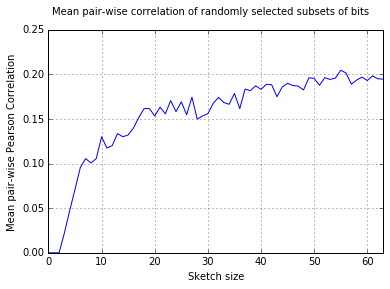

In [206]:
plot_array(found_corrs_mean[1],title='Mean pair-wise correlation of randomly selected subsets of bits', ylabel='Mean pair-wise Pearson Correlation', xlabel='Sketch size')

#### Algorithm 2
Select bits with minimal sum of values in correlation matrix M. This algorithm is O(n) and provides quite good results especially in terms of mean bit correlation.

In [207]:
found_corrs_max=list()
found_corrs_mean=list()

In [212]:
for length in sketch_lengths:
    if length<2:
        found_corrs_max.append(0.0)
        found_corrs_mean.append(0.0)
    else:
        indices=np.sum(M,axis=1).argsort()[:length]
        found_corrs_max.append(compute_max_corr(M, include=indices))
        found_corrs_mean.append(compute_mean_corr(M, include=indices))

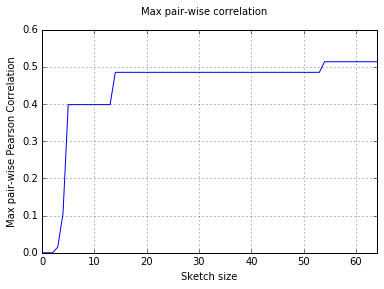

In [213]:
plot_array(found_corrs_max, title='Max pair-wise correlation', ylabel='Max pair-wise Pearson Correlation', xlabel='Sketch size')

Seems that even though maximum is high (0.5) further selected bits do not increase mean pair-wise correlation much.

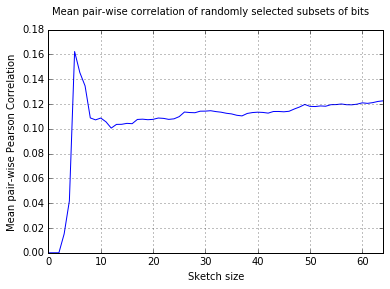

In [214]:
plot_array(found_corrs_mean,title='Mean pair-wise correlation of randomly selected subsets of bits', ylabel='Mean pair-wise Pearson Correlation', xlabel='Sketch size')

### Algorithm 3
Start with initial selected least correlated column (smallest sum in row) and add one in each iteration, which will result to minimal increase in correlation

In [373]:
def select_uncorrelated_bits(corr_mtx,desired_length,by='max'):
    '''
    Returned list of indices is sorted so least correlated sketches of lower size can be selected by indices[:desired_size].
    '''
    if desired_length<2:
        return 0.0,0.0,0.0
    least_correlated=np.argmin(np.sum(corr_mtx, axis=1))
    indices=list() #to keep them sorted
    indices_lookup=set() #to speed up search for membership
    indices.append(least_correlated)
    indices_lookup.add(least_correlated)
    corr_max=None
    corr_mean=None
    while(len(indices)<desired_length):
        best_i=None
        best_max_corr=100
        best_mean_corr=100
        for i in range(corr_mtx.shape[0]):                    
            if i not in indices_lookup:
                if by=='max':
                    corr_max=compute_max_corr(corr_mtx, include=list(indices)+[i])
                    if corr_max<best_max_corr:
                        best_i=i
                        best_max_corr=corr_max
                        best_mean_corr=compute_mean_corr(corr_mtx, include=list(indices)+[i])
                if by=='mean':
                    corr_mean=compute_mean_corr(corr_mtx, include=list(indices)+[i])
                    if corr_mean<best_mean_corr:
                        best_i=i
                        best_mean_corr=corr_mean
                        best_max_corr=compute_max_corr(corr_mtx, include=list(indices)+[i])
        indices_lookup.add(best_i)
        indices.append(best_i)
        corr_max=best_max_corr
        corr_mean=best_mean_corr
    return indices, corr_max, corr_mean


In [374]:
found_corrs_max=[list(),list()] #first by max, second by mean
found_corrs_mean=[list(),list()]
for sketch_len in sketch_lengths:
    _,corr_max, corr_mean=select_uncorrelated_bits(M, sketch_len,by='max')
    found_corrs_max[0].append(corr_max)
    found_corrs_mean[0].append(corr_mean)
    _,corr_max, corr_mean=select_uncorrelated_bits(M, sketch_len,by='mean')
    found_corrs_max[1].append(corr_max)
    found_corrs_mean[1].append(corr_mean)

#### Algorithm 3 - optimized by max

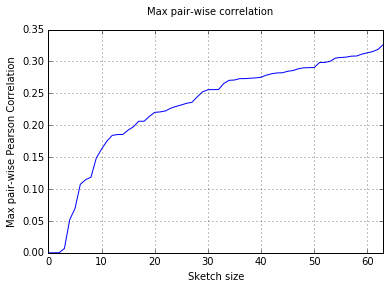

In [375]:
plot_array(found_corrs_max[0], title='Max pair-wise correlation', ylabel='Max pair-wise Pearson Correlation', xlabel='Sketch size')

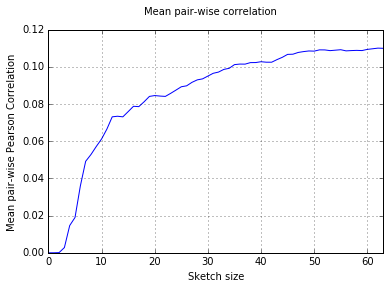

In [376]:
plot_array(found_corrs_mean[0],title='Mean pair-wise correlation', ylabel='Mean pair-wise Pearson Correlation', xlabel='Sketch size')

#### Algorithm 3 - optimized by mean

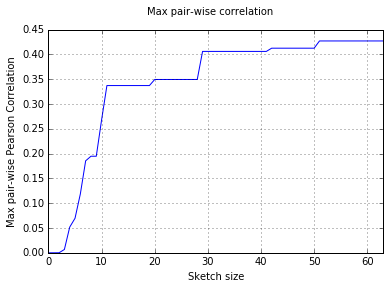

In [377]:
plot_array(found_corrs_max[1], title='Max pair-wise correlation', ylabel='Max pair-wise Pearson Correlation', xlabel='Sketch size')

It seems that you can get some bit with correlation almost 0.5 but still overall information redundancy among bits is below or close to 0.1.

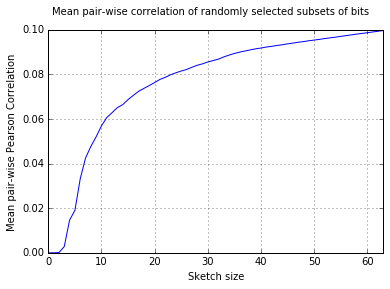

In [378]:
plot_array(found_corrs_mean[1],title='Mean pair-wise correlation of randomly selected subsets of bits', ylabel='Mean pair-wise Pearson Correlation', xlabel='Sketch size')

## CREATING SKETCH DATABASE FOR EVALUATION

We already transformed whole database into sketches of length over 4000 and then chosen 500 bits with top balance: 

In [379]:
partitions_bal.shape

(69318, 500)

Now we'll filter out unbalanced and correlated bits using Algorithm 3 with scoring by mean pairwise correlation:

In [380]:
indices, corr_max, corr_mean=select_uncorrelated_bits(M,128,by='mean')

In [381]:
corr_max #worst pair-wise correlation in our 128 bit sketchces

0.48514238222100681

In [382]:
corr_mean #mean pair-wise correlation in our 128 bit sketches

0.11488808991880463

Transform whole database to uncorrelated sketchces:

In [385]:
sketch_db=partitions_bal.T[indices].T

In [386]:
sketch_db.shape

(69318, 128)

Now rembember selected pivot couples:

In [387]:
ghp_pivot_vecs=pivot_cand_vecs_bal[indices]

In [388]:
ghp_pivot_vecs.shape

(128, 2, 4096)

Implementation of class transforming L_{p} vectors to sketches

In [389]:
class MinkowskiSketchCreator(object):
    def __init__(self, pivot_cpl_vecs, p=1,limit_len=None):
        self.pivots=pivot_cpl_vecs
        if limit_len is not None:
            self.pivots=self.pivots[:limit_len]
        self.p=p
        
    def get_ghp_partition(self, vec, pivot_a, pivot_b):
        '''
        returns partition 0/1 and distance to closest pivot
        '''
        dist_a=minkowski(vec, pivot_a, p=self.p)
        dist_b=minkowski(vec, pivot_b, p=self.p)
        if dist_a<dist_b:
            return 1
        if dist_a>dist_b:
            return 0
        return np.random.choice([0,1])
    
    def get_sketch(self, vec):
        return np.array([self.get_ghp_partition(vec, pivot_cpl[0],pivot_cpl[1])for pivot_cpl in self.pivots], dtype=np.float32)
            

In [390]:
sketch_creator=MinkowskiSketchCreator(ghp_pivot_vecs,limit_len=128)

Transform test set to sketchces:

In [391]:
test_sketch_db=np.array([sketch_creator.get_sketch(vec) for vec in test_vecs])

## Sketch properties Train vs Test dataset
We created sketches of test dataset which also contains decaf vectors but not those from training (sketch creation) dataset. No we'll examine whether and how did Sketch properties change.

In [392]:
sketch_db.shape

(69318, 128)

In [393]:
test_sketch_db.shape

(17330, 128)

In [394]:
def balance_score(db, aggregation_f=np.mean):
    return aggregation_f(np.array([compute_part_balance(sum(col),col.shape[0]) for col in db.T]))

def correlation(db, by='max'):
    corr_mtx=compute_corr_mtx(db)
    if by=='max':
        return compute_max_corr(corr_mtx)
    if by=='mean':
        return compute_mean_corr(corr_mtx)

##### Balance
Balancing score of both is almost the same.

In [395]:
balance_score(sketch_db)

0.94125421066678205

In [396]:
balance_score(test_sketch_db)

0.94104425129832658

#### Correlation Train vs Test
Correlation both max and mean turned out to be almost the same on both datasets.

Maximal

In [401]:
correlation(sketch_db, by='max')

0.48514238222100659

In [402]:
correlation(test_sketch_db, by='max')

0.47824447167579881

Mean

In [403]:
correlation(sketch_db, by='mean')

0.11488808991880466

In [404]:
correlation(test_sketch_db, by='mean')

0.11529227659358245

## APPROXIMATION QUALITY EVALUATION

In [57]:
decaf_vecs, eval_queries_vecs,\
eval_queries_ids, eval_k, \
pivot_cand_vecs,eval_result_objs,\
pivot_cand_ids, partitions, balance_scores,\
avg_dist_from_hp

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.77862   ],
        [ 0.        ,  0.        ,  1.26993001, ...,  0.        ,
          1.78074002,  0.        ],
        [ 0.0255054 ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.265892  ],
        ..., 
        [ 1.40979004,  0.        ,  2.54503012, ...,  0.292346  ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.50771999,  0.0940702 ],
        [ 0.0247422 ,  4.9530201 ,  0.949458  , ...,  0.        ,
          1.11435997,  0.        ]], dtype=float32),
 array([[  0.00000000e+00,   0.00000000e+00,   1.44812000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   5.13181984e-02,   3.87248993e-01, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00